# Library Import

In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
# faster rcnn model이 포함된 library
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

# for EDA
import matplotlib.pyplot as plt
import PIL
import torchvision.transforms as transforms
from PIL import ImageFont, ImageDraw, Image

# Tensorboard
import torch
from torch.utils.tensorboard import SummaryWriter

# Dataset 생성

In [2]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        # torchvision faster_rcnn은 label=0을 background로 취급
        # class_id를 1~10으로 수정 
        labels = np.array([x['category_id']+1 for x in anns]) 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [11]:
def get_train_transform():
    return A.Compose([
        A.Resize(1024, 1024),
        # A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Visualization

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


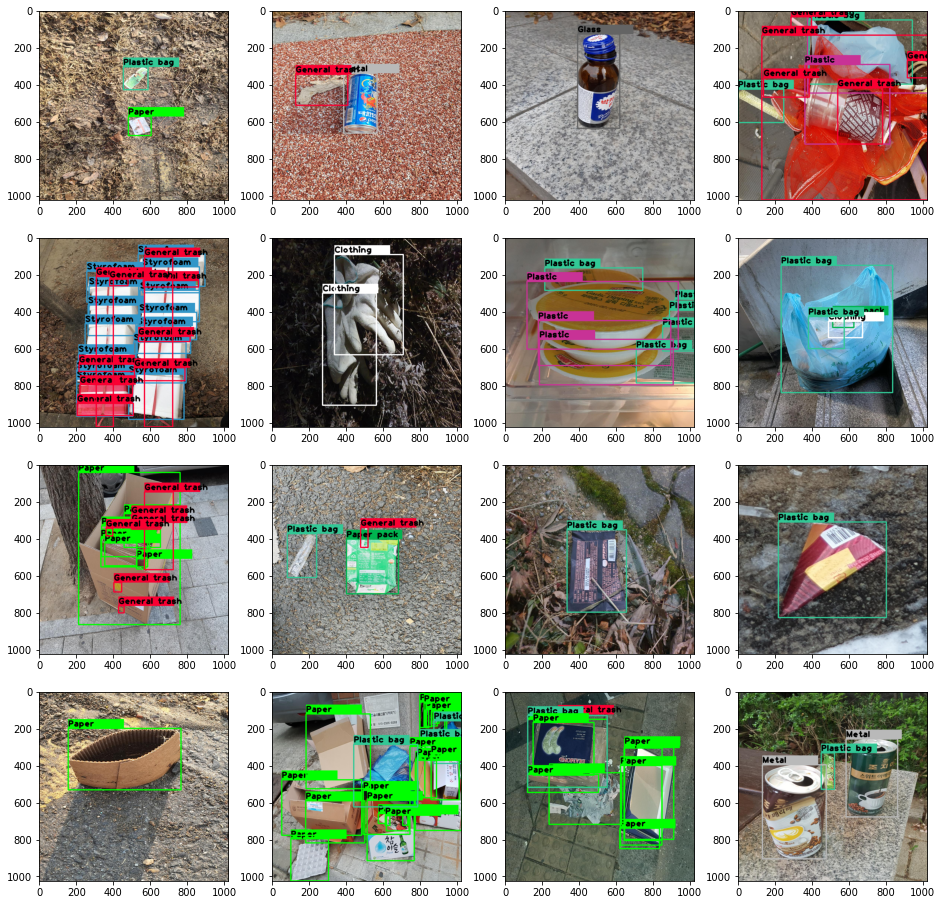

In [13]:
# 데이터셋 불러오기
annotation = '../dataset/train.json' # annotation 경로
data_dir = '../dataset' # data_dir 경로
train_dataset = CustomDataset(annotation, data_dir, get_train_transform()) 

class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [(250,0,50), (0, 255, 0), (0, 180, 80), (185, 185, 185), (100, 100, 100), (200, 50, 150), (50, 150, 200), (50, 200, 150), (200, 200, 200), (255,255,255)]

import random

# 데이터셋 확인하기
plt.figure(figsize=(16,16))
for i in range(16):
    ran_num = random.randrange(1, 4884)
    
    im = train_dataset[ran_num][0].permute(1, 2, 0).numpy()
    im = (im * 255).astype(np.uint8)

    for j in range(len(train_dataset[ran_num][1]['labels'])):

        label_idx = train_dataset[ran_num][1]['labels'][j]-1
        box = list(map(int, train_dataset[ran_num][1]['boxes'][j]))
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), class_color_list[label_idx], 5)

        text = class_name_list[label_idx]    
        cv2.rectangle(im, (box[0], box[1] - 50), (box[0] + 300, box[1]), class_color_list[label_idx], -1)
        cv2.putText(im, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 5, cv2.LINE_AA)

    plt.subplot(4, 4, i+1)
    # plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(im)